## PyTorch и полносвязные нейронные сети

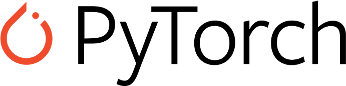

## 1. Установка PyTorch

`conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia`

В данном ноутбуке мы будем пользоваться фреймворком **PyTorch**, который предназначен для работы с нейронными сетями. Как установить `torch` можно прочитать <a href="http://pytorch.org/" target="_blank">на официальном сайте PyTorch</a>. Для этого выберите свою OS, и вам будет показана нужная команда для ввода в терминале. Больше подробностей о том, как работает `torch`, будет рассказано позднее.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
sns.set_theme(palette='Set2', font_scale=1.5)
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim

print(torch.__version__)

2.1.0+cu121


## 2. Простой пример обучения нейронной сети

### 2.1 Цикл обучения модели

Пусть задана нейронная сеть $f(x)$, параметризуемая обучаемыми параметрами $\theta$. Для входных данных $x$ модель возвращает $\widehat{y}=f(x)$. Для обучения модели необходимо задать оптимизируемую функцию (функцию ошибки, лосс) $L(y, \widehat{y})$, которую следует минимизировать.


Процесс обучения задается следующим образом.
 1. **Прямой проход / Forward pass:** <br>
     Считаем $\widehat{y}=f(x)$ для входных данных $x$. <br>
 2. **Вычисление оптимизируемой функции:**<br>
     Вычисляем оптимизируемую функцию $L(y, \widehat{y})$. <br>
 3. **Обратный проход / Backward pass:** <br>
     Считаем градиенты по всем обучаемым параметрам $\frac{\partial L}{\partial \theta}$. <br>
 4. **Шаг оптимизации:** <br>
     Делаем шаг градиентного спуска, обновляя все обучаемые параметры. <br>

### 2.2 Линейная регрессия

Линейную регрессию можно представить как частный случай нейрона с тождественной функцией активации.

Сделаем одномерную линейную регрессию на датасете <a href="http://lib.stat.cmu.edu/datasets/boston" target="_blank">boston</a>. Этот датасет представляет собой набор данных конца 70-х годов прошлого века для предсказания цены недвижимости в Бостоне.

Скачиваем данные.

In [9]:
def load_boston(file_path='./boston.csv'):
    # выделяем признаки и таргет
    raw_df = pd.read_csv(file_path)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]
    return data, target

In [3]:
data, target = load_boston()

In [4]:
data.shape, target.shape

((506, 13), (506,))

Будем рассматривать зависимость таргета, т.е. медианной стоимости домов в тысячах долларов, от последнего признака, т.е. процента населения людей с низким уровнем дохода.

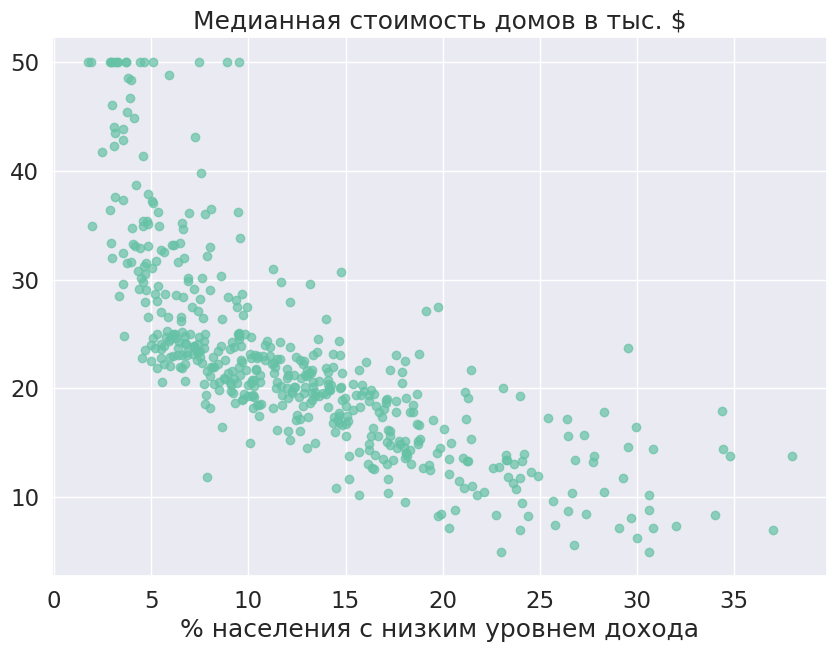

In [5]:
plt.figure(figsize=(10, 7))
plt.scatter(data[:, -1], target, alpha=0.7)
plt.xlabel('% населения с низким уровнем дохода')
plt.title('Медианная стоимость домов в тыс. $');

В данном случае предсказание модели задается следующим образом: $$\widehat{y}(x) = wx + b,$$
где $w, b \in \mathbb{R}$ &mdash; обучаемые параметры модели. Это обычная линейная модель, и с ней мы уже работали ранее.


На практике для построения нейронных пользуются готовыми модулями. Для этого будем пользоваться `torch.nn`.

Воспользуемся следующими модулями:

* `nn.Sequential` &mdash; модуль для соединения модулей последовательно, друг за другом;
* `nn.Linear` &mdash; модуль линейного слоя;

В линейный слой нужно передать 2 параметра:
* `in_features` &mdash; количество признаков на входе в линейный слой
* `out_features` &mdash; количество признаков на выходе из линейного слоя

Для нашей модели сделайте `in_features` = `out_features` = 1

С тем как задавать нейронную сеть с помощью модуля Sequential можно ознакомиться по <a href="https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html" target="_blank">ссылке</a>.

In [6]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=1)
    )
model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

Инициализируем веса модели нулевыми тензорами. Тензор в `pytorch` &mdash; практически полный аналог `numpy.array`, но с возможностью считать сложные производные и умножать матрицы параллельно на видеокарте. Мы пока работаем без ГПУ. По умолчанию веса генерируются случайным образом (подробнее <a href="https://pytorch.org/docs/stable/generated/torch.nn.Linear.html" target="_blank">тут</a>).

In [7]:
# Здесь на это можно и забить
for p in model.parameters():
    p.data = torch.FloatTensor([[0]])
    print(p.data)

tensor([[0.]])
tensor([[0.]])


Зададим признак $X$ и таргет $Y$ в виде `torch`-тензоров. Помимо этого для того, чтобы работать с нашей моделью, нам необходимо поменять размерность `x` и `y`.

In [8]:
x = torch.FloatTensor(data[:, -1]/10).reshape(-1, 1)
y = torch.FloatTensor(target).reshape(-1, 1)

x.shape, y.shape

(torch.Size([506, 1]), torch.Size([506, 1]))

Разбейте данные на тренировочную и валидационную выборки в соотношении 4:1

In [10]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

torch.Size([404, 1]) torch.Size([404, 1]) torch.Size([102, 1]) torch.Size([102, 1])


Зададим оптимизируемую функцию / функцию ошибки / лосс. В нашем случае это будет MSE:

$$
\mathrm{MSE}(\widehat{y}, y) = \frac{1}{n} \sum_{i=1}^n \left(\widehat{y}_i - y_i\right)^2.
$$

Воспользуемся реализацией из пакета PyTorch

In [11]:
optim_func = nn.MSELoss()

Будем оптимизировать функцию ошибки с помощью метода `SGD` из `torch`, который реализует стохастический градиентный спуск. Он принимает на вход параметры модели, их мы можем получить, вызвав метод `parameters` у модели, и скорость обучения `lr`, которую мы обозначали ранее как $\eta$. У оптимизатора есть возможность задать некоторые другие аргументы или вообще выбрать друго алгоритм оптимизации. Но об этом сильно позднее (а если очень интересно, то можно почитать  <a href="https://pytorch.org/docs/stable/optim.html" target="_blank">тут</a>).

Установим скорость обучения на уровне $0.01$ для всех параметров сразу.

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

Обучим полученную модель на наших данных. Теперь обновления значений параметров происходят с помощью вызова `optimzer.step()`, а зануление градиентов &mdash; с помощью `optimizer.zero_grad()`.

In [13]:
def show_progress(x, y, y_pred, loss):
    '''
    Визуализация процесса обучения.

    x, y -- объекты и таргеты обучающей выборки;
    y_pred -- предсказания модели;
    loss -- текущее значение ошибки модели.
    '''

    # Открепим переменную от вычислительного графа перед отрисовкой графика
    y_pred = y_pred.detach()

    # Превратим тензор размерности 0 в число
    loss = loss.item()

    # Стираем предыдущий вывод в тот момент, когда появится следующий
    clear_output(wait=True)

    # Строим новый график
    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.75)
    plt.scatter(x, y_pred, color='orange', linewidth=5)
    plt.xlabel('% населения с низким уровнем дохода')
    plt.title('Медианная стоимость домов в тыс. $')
    plt.show()

    print(f"MSE = {loss:.3f}")

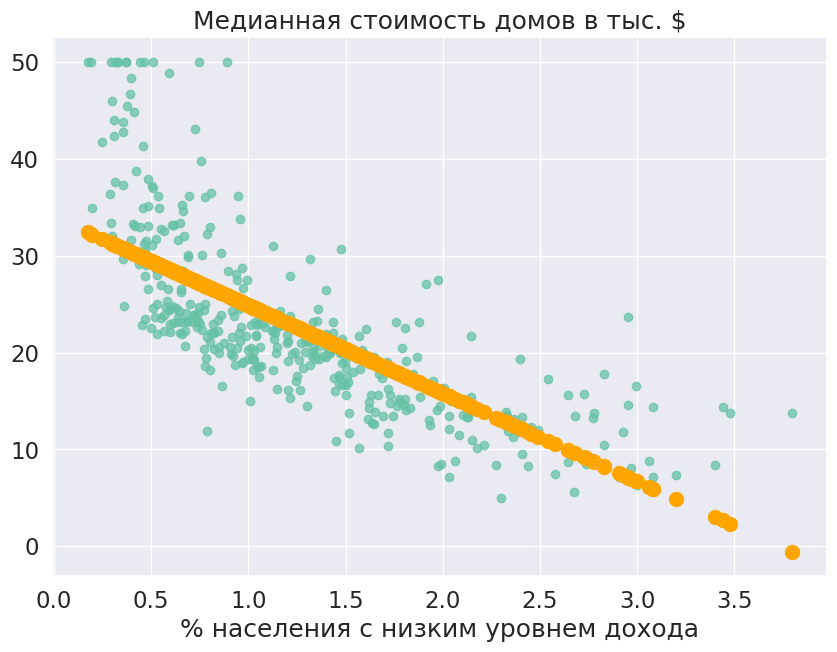

MSE = 39.948


In [14]:
num_iter = 1000
for i in range(num_iter):
    # Шаг 1.
    # Forward pass: предсказание модели по обучающим данным
    y_pred = model(X_train)

    # Шаг 2.
    # Вычисление оптимизируемой функции (MSE) по предсказаниям
    loss = optim_func(y_pred, y_train)

    # Шаг 3.
    # Backward pass: вычисление градиентов оптимизируемой функции
    # по всем параметрам модели
    loss.backward()

    # Шаг 4.
    # Оптимизация: обновление параметров по формулам соответствующего
    # метода оптимизации, используются вычисленные ранее градиенты
    optimizer.step()

    # Зануление градиентов
    optimizer.zero_grad()

    # График + вывод MSE через каждые 10 итераций
    if (i + 1) % 10 == 0:
        show_progress(X_train, y_train, y_pred, loss)

Посчитайте MSE на валидационной выборке

In [16]:
print(f'Значение MSE на валидационной выборке: {optim_func(model(X_val), y_val).item():.3}')

Значение MSE на валидационной выборке: 33.1


### 2.3 Улучшение модели

Попробуем усложнить модель, добавив еще один слой. Тем самым модель примет следующий вид

$$\widehat{y}(x) = w_2u(x) + b_2,$$

$$u(x) = \sigma(w_1x + b_1),$$

$$\sigma(x) = \text{ReLU}(x) = \begin{equation*}\begin{cases}x, \; x \ge 0, \\ 0, \; \text{иначе,} \end{cases} \end{equation*}$$

$w_1, b_1 \in \mathbb{R}$ &mdash; обучаемые параметры первого слоя, $w_2, b_2 \in \mathbb{R}$ &mdash; обучаемые параметры второго слоя, $\sigma(x)$ &mdash; функция активации, в данном случае `ReLU`.

Соберите все модули в одну модель. Теперь, помимо одного линейного слоя, у вас должны быть функция активации и второй линейный слой. Оставьте `in_features` = `out_features` = 1 для обоих линейных слоев.

In [17]:
model = nn.Sequential(
    nn.Linear(in_features = 1, out_features = 1),
    nn.ReLU(),
    nn.Linear(in_features = 1, out_features = 1)
)

for i in model.parameters():
    i.data = torch.FloatTensor([[0]])

print(model)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
)


Инициализируем веса

In [18]:
for name, param in model.named_parameters():
    param.data = torch.FloatTensor([[1]])
    print(name)
    print(param.data)

0.weight
tensor([[1.]])
0.bias
tensor([[1.]])
2.weight
tensor([[1.]])
2.bias
tensor([[1.]])


Имена `0.weight` и `0.bias` соответствуют весу $w_1$ и сдвигу $b_1$ первого слоя, аналогично, `2.weight` и `2.bias` соответствуют весу $w_2$ и сдвигу $b_2$ второго слоя. Заметим, что в названии параметров есть индексы $0$ и $2$, но нет индекса $1$, т.к. $0$-й и $2$-й модули в модели представлены линейными слоями, а $1$-й модуль &mdash; функцией активации, у которой нет обучаемых параметров.

Запустим модель на обучение. Реализуйте обучение по аналогии с предыдущим пунктом

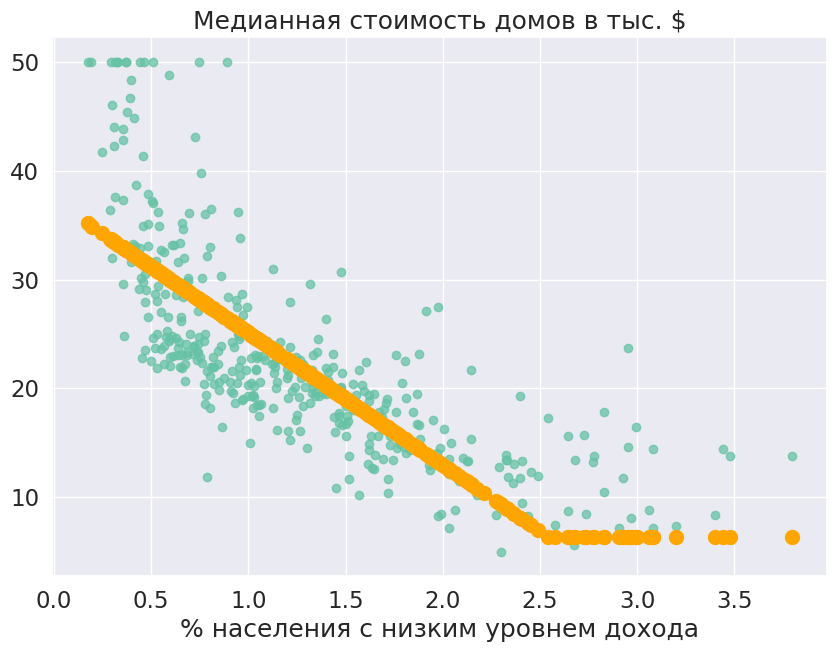

MSE = 37.070


In [19]:
optimizer = optim.SGD(model.parameters(), lr = 0.01)

optim_func = nn.MSELoss()

num_iter = 1000
for i in range(num_iter):

    y_pred = model(X_train)

    loss = optim_func(y_pred, y_train)

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()

    if (i + 1) % 10 == 0:
        show_progress(X_train, y_train, y_pred, loss)

Какое значение MSE в этот раз получилось на валидации?

In [20]:
val_loss = optim_func(model(X_val), y_val).item()
print(f'Значение MSE на валидационной выборке: {val_loss:.3}')

Значение MSE на валидационной выборке: 31.9


**Выводы**

Видно, что после улучшения модели значение MSE на валидационной выборке уменьшилось с 33.1 до 31.9. Поэтому можно сделать вывод о том, что изменения в архитектуре модели и в параметрах обучения, привели к улучшению.

**Небольшое лирическое отступление**

Что же может произойти, если мы инциализирум веса случайным образом? Давайте ещё посмотрим на функцию ReLU.
$$\sigma(x) = \text{ReLU}(x) = \begin{equation*}\begin{cases}x, \; x \ge 0, \\ 0, \; \text{иначе} \end{cases} \end{equation*}$$

Соответственно производная этой функции активации:
$$\sigma'(x) = \begin{equation*}\begin{cases}1, \; x \ge 0, \\ 0, \; \text{иначе} \end{cases} \end{equation*}$$

При обновлении веса могут стать сильно отрицательными. Так как градиент ReLU для отрицательных значений нулевой – мы можем за все время обучения их ни разу не обновить. Этот эффект называется <a href="https://www.educative.io/answers/what-is-the-dying-relu-problem" target="_blank">dying ReLU problem</a>.

Если интересно, можете попробовать позапускать обучение модели со случайными начальными весами и самим убедиться, что модель может и не обучиться...

### 2.4 Ещё больше усложним модель

А теперь к предыдущей модели добавим ещё один слой активации и ещё один линейный слой. Здесь уже можете попробовать поварьировать параметры обучения. Если будете это делать, то не забудьте сделать отчет по вашим экспериментам

На практике обычно смотрят на то, как меняется лосс во время обучения. Реализуйте функцию, по аналогии с show_progress, которая будет отрисовывать не только предсказания модели, но еще и её лосс за все предыдущие итерации обучения. Не забудьте адаптировать шаблон функции обучения под эту задачу

In [21]:
def show_progress(x, y, y_pred, losses):
    '''
    Визуализация процесса обучения.

    x, y -- объекты и таргеты обучающей выборки;
    y_pred -- предсказания модели;
    losses -- значение ошибки модели со всех итераций обучения.
    '''

    # Открепим переменную от вычислительного графа перед отрисовкой графика
    y_pred = y_pred.detach()

    # Стираем предыдущий вывод в тот момент, когда появится следующий
    clear_output(wait=True)

    # Строим новый график
    fig, ax = plt.subplots(2, 1, figsize = (10, 10))
    # График предсказаний
    ax[0].scatter(x, y, alpha=0.75)
    ax[0].scatter(x, y_pred, color='orange', linewidth=5)
    ax[0].set_xlabel('% населения с низким уровнем дохода')
    ax[0].set_title('Медианная стоимость домов в тыс. $')

    #Теперь добавляем график с лосс-функцией
    ax[1].plot(losses, label = 'MSE Loss')

    # Добавляем заголовок и подписи по осям
    ax[1].set_xlabel('Итерации обучения')
    ax[1].set_ylabel('Значение Loss')
    ax[1].set_title('Динамика функции потерь')
    ax[1].legend()

    # Чтобы подписи не перекрывались
    fig.tight_layout()

    plt.show()

    print(f"MSE = {losses[-1]:.3f}")

По-хорошему, надо выводить изменения лосса как на тренировочной, так и на валидационной выборках, чтобы не допустить переобучения, но пока обойдемся лишь тестовой выборкой

Обучите модель

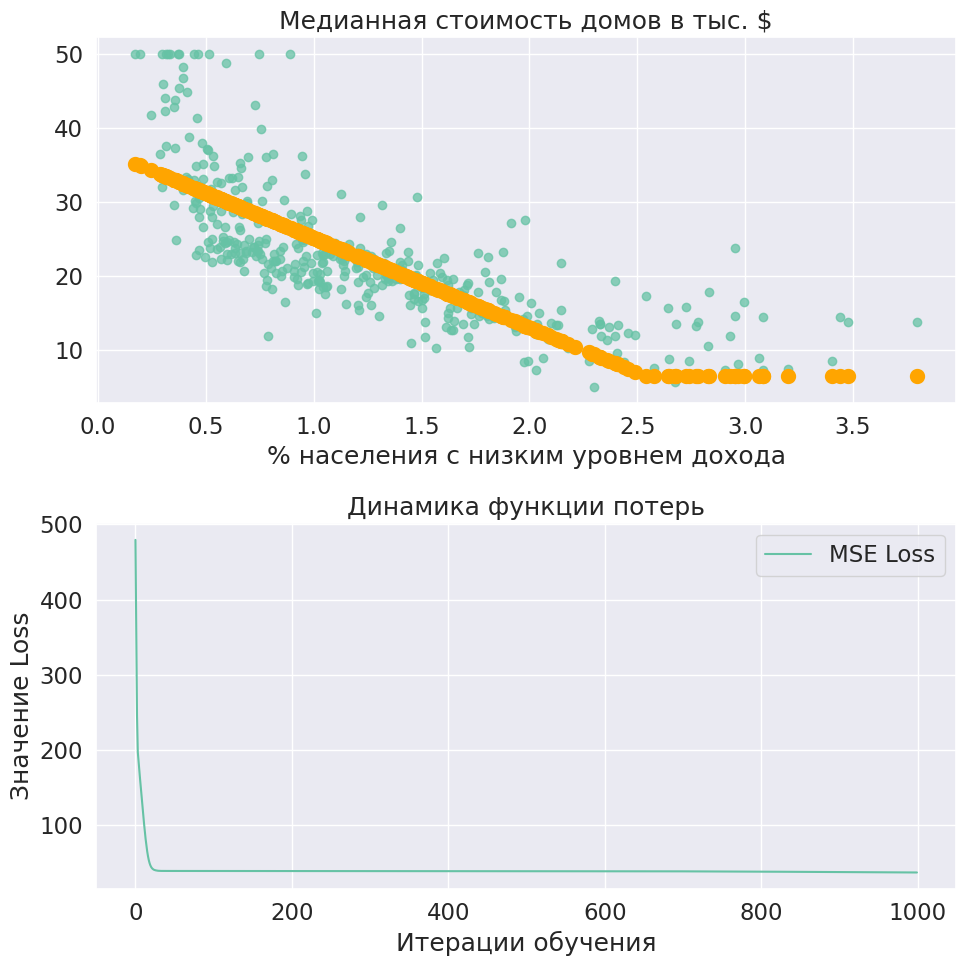

MSE = 37.070
Финальное значение MSE на тренировочной выборке: 37.070
Финальное значение MSE на валидационной выборке: 31.857


In [23]:
for name, param in model.named_parameters():
    param.data = torch.FloatTensor([[1]])
    print(name)
    print(param.data)

optimizer = optim.SGD(model.parameters(), lr = 0.01)

optim_func = nn.MSELoss()

num_iter = 1000
train_losses = []
val_losses = []

for i in range(num_iter):
    y_pred_train = model(X_train)

    loss_train = optim_func(y_pred_train, y_train)

    loss_train.backward()

    optimizer.step()

    optimizer.zero_grad()

    train_losses.append(loss_train.item())

    y_pred_val = model(X_val)
    loss_val = optim_func(y_pred_val, y_val)

    val_losses.append(loss_val.item())

    if (i + 1) % 10 == 0:
        show_progress(X_train, y_train, y_pred_train, train_losses)

print(f'Финальное значение MSE на тренировочной выборке: {train_losses[-1]:.3f}')
print(f'Финальное значение MSE на валидационной выборке: {val_losses[-1]:.3f}')

Не забываем про выводы)

**Итоговый вывод:**

1. Первоначальная модель, состоящая из одного линейного слоя, демонстрировала MSE на валидационной выборке в районе 33.1 до улучшения.

2. Добавление слоя с функцией активации ReLU и второго линейного слоя помогло нам улучшить модель. В результате обучения значение MSE на валидационной выборке снизилось с 33.1 до 31.9.

3. При добавлении ещё одного слоя с функцией активации и линейного слоя значение MSE на валидационной выборке уменьшилось, но осталось довольно высоким (37.070 на тренировочной выборке и 31.857 на валидационной). Возможно, это может свидетельствовать о переобучении.